#LIBRERIAS

In [27]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
#import pytorch_lightning as pl
import torch.nn as nn
from scipy.stats import bernoulli
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mutual_info_score
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy_indexed as npi
from tqdm import tqdm

## Creacion de datos

In [28]:
df=pd.read_csv("datasets/hd_dataset.csv")
df.head()


,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63,male,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,yes
1,1,37,male,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,yes
2,2,41,female,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,yes
3,3,56,male,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,yes
4,4,57,female,0,NaN,354.0,0,1,163.0,1,0.6,2,0,2,yes


In [29]:
df = df.drop(df.columns[0], axis=1)
#df = df.drop(df.columns[0], axis=1)

In [30]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for c in df.columns[0:]:
    if(df[c].dtype == 'object'):
        df[c] = encoder.fit_transform(df[c])
    else:
        df[c] = df[c]
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145.0,233.0,1,0,150.0,0,2.3,0,0,1,1
1,37,1,2,130.0,250.0,0,1,187.0,0,3.5,0,0,2,1
2,41,0,1,130.0,204.0,0,0,172.0,0,1.4,2,0,2,1
3,56,1,1,120.0,236.0,0,1,178.0,0,0.8,2,0,2,1
4,57,0,0,NaN,354.0,0,1,163.0,1,0.6,2,0,2,1


In [31]:
df = df.fillna(0)

In [32]:
y = df["target"]

In [33]:
df_scaled = df.copy()

In [34]:
df_scaled.pop("target")

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = pd.DataFrame(scaler.fit_transform(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]))

In [36]:
#voy a tratar de binarizar a ver que pasa
# Lista de columnas a binarizar

columnas_a_binarizar = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Binarizar solo las columnas especificadas según su propia media
df_scaled[columnas_a_binarizar] = df_scaled[columnas_a_binarizar].apply(lambda x: (x > x.mean()).astype(int))


In [37]:
x = df_scaled


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.40)

## Clasificador de informacion mutua


#entrenamiento

In [39]:
def find_row_index(matrix, target_row):
    for i, row in enumerate(matrix):
        if np.array_equal(row, target_row):
            return i
    return -1

entradas que bajan: [0,2,7,8,9,10,11,12]
las 3 mas relevantes: X=X[:,[2,11,12]]

In [40]:
def estimador(X,Y, n= np.arange(0,13)):
  """
  X corresponde al primer vector, y Y al segundo. [0,2,7,8,9,10,11,12]
  """
  X=X[:,n]
  x_comp, x_num =  npi.count(X)
  y_comp, y_num = npi.count(Y)
  XY = np.concatenate((X, Y), axis=1)
  xy_comp, xy_num = npi.count(XY)
  IM = 0

  for x in x_comp:
    for y in y_comp:

      xy = np.concatenate((x, y))
      index_xy = find_row_index(xy_comp,xy)
      pxy = xy_num[index_xy]/np.sum(xy_num)

      index_x = find_row_index(x_comp,x)
      px =  x_num[index_x]/np.sum(x_num)

      index_y = find_row_index(y_comp,y)
      py =  y_num[index_y]/np.sum(y_num)
      IM += pxy * np.log2(pxy/(px*py))
  return IM


## Modelo

In [41]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_layer = nn.Linear(input_dim,hidden_dim)
        self.hidden_layer = nn.Linear(hidden_dim,output_dim)
        self.act_fn = nn.ReLU()
    def forward(self, x):
        x = self.input_layer(x)
        x = self.act_fn(x)
        x = self.hidden_layer(x)
        return x


## Creacion de datos

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 20
epochs = 1500

In [43]:
input = x_train.shape[1]

In [44]:
n_experimento = 4

In [45]:
model = MLP(input_dim = input ,hidden_dim = 40,output_dim=2)
model = model.to(device)
lr_exp = 0.2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr_exp)
loss_fn = nn.CrossEntropyLoss()

In [46]:
x_train_tensor = torch.tensor(x_train.values)
y_train_tensor = torch.tensor(y_train.values).view(-1,1)
x_val_tensor = torch.tensor(x_test.values)
y_val_tensor = torch.tensor(y_test.values).view(-1,1)

In [47]:
# Create TensorDatasets
train_data = TensorDataset(x_train_tensor, y_train_tensor)
val_data = TensorDataset(x_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size = batch_size)

In [48]:
y_val_tensor.shape

torch.Size([122, 1])

In [49]:
# Create lists to store metrics
from sklearn.metrics import accuracy_score
########
losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_accuracies = []
y_epochs = []
x_epochs = []
y_hat_epochs = []

# Training loop
for epoch in range(epochs):
    model.train()
    y_batches = []
    x_batches = []
    y_hats = []
    correct_train = 0
    total_train = 0
    total_loss = 0  # Initialize total_loss
    total_samples = 0  # Initialize total_samples

    true_labels_train = []
    predicted_labels_train = []
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device)  # Ensure target is of type Long

        optimizer.zero_grad()
        y_hat = model(x_batch)

        loss = loss_fn(y_hat, y_batch.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(y_hat)
        total_samples += len(y_hat)


        y_batches.append(y_batch.detach().cpu().numpy())
        x_batches.append(x_batch.detach().cpu().numpy())
        y_hats.append(torch.argmax(y_hat,dim=1).detach().cpu().numpy())

        _, predicted = torch.max(y_hat, 1)
        true_labels_train.extend(y_batch.cpu().numpy())
        predicted_labels_train.extend(predicted.cpu().numpy())

    train_accuracy = accuracy_score(true_labels_train, predicted_labels_train)
    train_accuracies.append(train_accuracy)

    losses.append(total_loss / total_samples)
    y_epochs.append(np.concatenate(y_batches))
    x_epochs.append(np.concatenate(x_batches))
    y_hat_epochs.append(np.concatenate(y_hats))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss_epoch = 0
        correct_val = 0
        total_val = 0
        true_labels_val = []
        predicted_labels_val = []

        for x_val_batch, y_val_batch in val_loader:
            x_val_batch = x_val_batch.to(device).float()
            y_val_batch = y_val_batch.to(device)  # Ensure target is of type Long

            val_outputs = model(x_val_batch)
            val_loss = loss_fn(val_outputs, y_val_batch.view(-1))
            val_loss_epoch += val_loss.item() * len(y_val_batch)
            total_val += y_val_batch.size(0)

            _, predicted_val = torch.max(val_outputs, 1)
            true_labels_val.extend(y_val_batch.cpu().numpy())
            predicted_labels_val.extend(predicted_val.cpu().numpy())


    val_losses.append(val_loss_epoch / total_val)

    val_accuracy = accuracy_score(true_labels_val, predicted_labels_val)
    val_accuracies.append(val_accuracy)

overfit = np.argmin(val_losses)


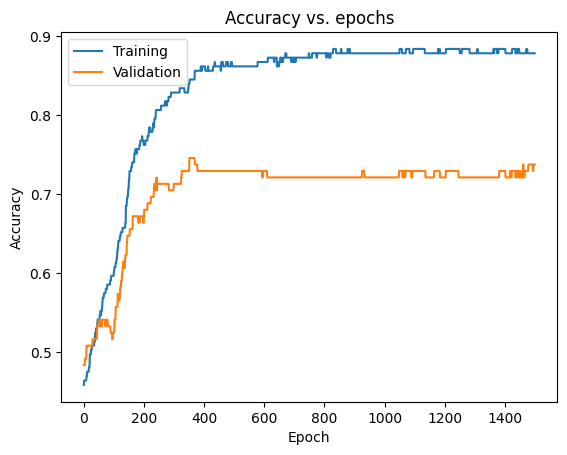

In [50]:
plt.plot(range(epochs),train_accuracies)
plt.plot(range(epochs),val_accuracies)
plt.title('Accuracy vs. epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig(f"experimento-{n_experimento}-accuracy")
plt.legend(['Training','Validation'])


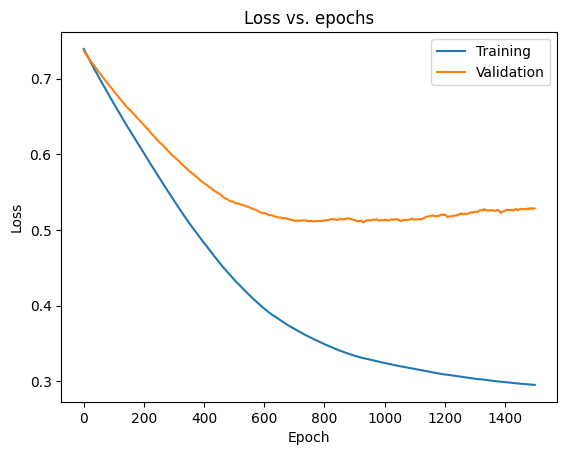

In [51]:
plt.plot(range(epochs),losses)
plt.plot(range(epochs),val_losses)
plt.title('Loss vs. epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(f"experimento-{n_experimento}-loss")
plt.legend(['Training','Validation'])

In [52]:
@np.vectorize
def binarizar(x):
    return 1 if x >= 0.5 else 0

In [53]:
from scipy.stats import entropy

np.random.seed(seed=101)
def H(X):
    """
    This function calculates the entropy for binary variables
    """
    N = len(X)
    p = np.sum(X)/N
    if (p == 0) or (p == 1):
        return 0
    return p * np.log2((1-p)/p) - np.log2(1-p)


In [54]:
Rs_new = []
for epoch in range(epochs):
    y = np.concatenate(y_epochs[epoch])
    y_hat = y_hat_epochs[epoch].reshape(-1)
    Rs_new.append(np.abs(y_hat-y ))

In [58]:
np.array(Rs_new).shape

(1500, 181)

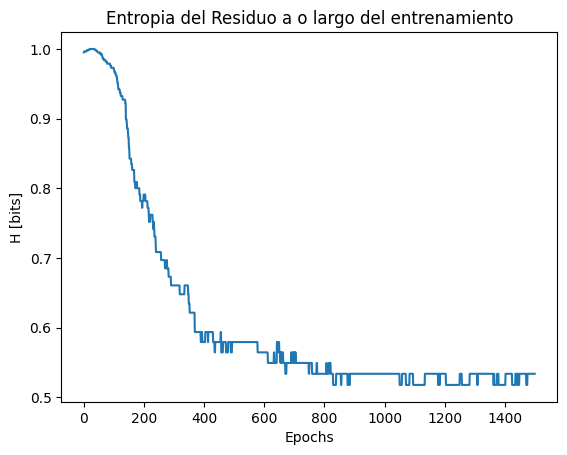

In [55]:
Hs= [H(np.array(r)) for r in Rs_new]
plt.plot(Hs)
plt.title("Entropia del Residuo a o largo del entrenamiento")
plt.xlabel("Epochs")
plt.ylabel("H [bits]")
plt.savefig(f"experimento-{n_experimento}-Entropia-del-Residuo")

In [56]:
from sklearn.feature_selection import mutual_info_regression
def estimador2(x,y):
    #return mutual_info_classif(x,y,n_neighbors=3)
    return mutual_info_regression(x,y,n_neighbors=5)

In [59]:
np.array(x_epochs).shape

(1500, 181, 13)

In [61]:
Rs_new1 = np.array(Rs_new).reshape(epochs,181,1) #si quiero el estimador1
mi_r_x = []
for epoch in tqdm(range(epochs)):
    mi_r_x.append(estimador2(x_epochs[epoch],Rs_new[epoch].ravel()))


100%|██████████| 1500/1500 [00:22<00:00, 66.77it/s]


In [62]:
np.array(mi_r_x).shape

(1500, 13)

In [63]:
mi_r_x_e = []
n=10
mi_r_x= np.array(mi_r_x)
print(np.mean(mi_r_x[:n],axis=0))
indices_mas_altos = np.argpartition(np.mean(mi_r_x[:n],axis=0), -3)[-3:]
for epoch in tqdm(range(epochs)):
    mi_r_x_e.append(estimador(x_epochs[epoch],Rs_new1[epoch], indices_mas_altos))

[0.04687795 0.0311353  0.07104163 0.02149789 0.00612057 0.02890009
 0.05599681 0.04917083 0.07908942 0.02128905 0.02850402 0.07620688
 0.09128999]


100%|██████████| 1500/1500 [00:05<00:00, 253.70it/s]


In [64]:
indices_mas_altos

array([11,  8, 12])

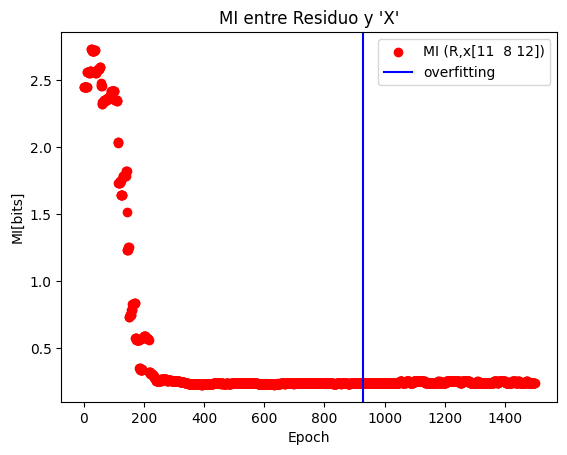

In [65]:
plt.scatter(range(len(mi_r_x_e)),mi_r_x_e, c = "red", label = f"MI (R,x{indices_mas_altos})")
plt.axvline(x = overfit, color = 'b', label = 'overfitting')
plt.title("MI entre Residuo y 'X'")
plt.legend()
plt.ylabel('MI[bits]')
plt.xlabel('Epoch')
plt.savefig(f"experimento-{n_experimento}-MI-mejor-comp")


In [66]:
import itertools
MI_mean = []
n= 5
for i in range(np.array(mi_r_x).shape[0]):
    MI_mean.append(np.mean(np.array(mi_r_x[i])))
MI_mean = list(itertools.chain.from_iterable([i]*n for i in [np.mean(MI_mean[i:i+n]) for i in range(0,len(MI_mean),n)]))

In [67]:
mi_r_x.shape

(1500, 13)

Text(0.5, 1.0, 'Promedio de MI(R,x) cada 10 Epochs')

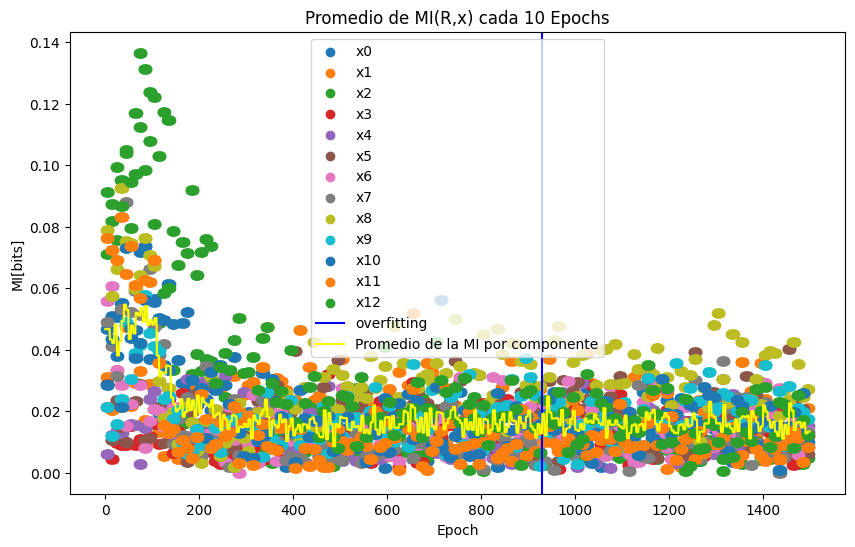

In [68]:

n= 10
mi_r_x = np.array(mi_r_x)
plt.figure(figsize=(10,6))
for i in range(np.array(mi_r_x).shape[1]):
    list1 = mi_r_x[:,i]
    list1 = list(itertools.chain.from_iterable([i]*n for i in [np.mean(list1[i:i+n]) for i in range(0,len(list1),n)]))
    plt.scatter(range(len(mi_r_x)),list1, label = 'x'+str(i))
plt.axvline(x = overfit, color = 'b', label = 'overfitting')
plt.plot(range(len(mi_r_x)),MI_mean, label = "Promedio de la MI por componente", c= 'yellow')
plt.ylabel('MI[bits]')
plt.xlabel('Epoch')
plt.legend()
plt.savefig(f"experimento-{n_experimento}-MI-por-componente-lr-{lr_exp}.jpg")
plt.title(f'Promedio de MI(R,x) cada {n} Epochs')